# COMP6248 Reproducibility Challenge
## Title: EFFICIENT AUGMENTATION VIA DATA SUBSAMPLING

### Team alpha
Mateusz Pietrkiewicz & Arnold Gabriel Benedict & Sunwung Lee

{mp8n19,agb1n19,sl7a19}@soton.ac.uk

In [1]:
from tensorflow import keras
from keras.datasets import mnist
from keras.datasets import cifar10
from torch import optim
import imgaug.augmenters as iaa
from torch import nn
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np

SET_MNIST, SET_CIFAR, SET_NORB = 0,1,2
LEARN_MODEL = True

Using TensorFlow backend.


### Augmentation methods

In [4]:
def translate(X, x_mag_aug, y_mag_aug):
  result = iaa.Affine(translate_px={"x": (x_mag_aug, x_mag_aug), "y": (y_mag_aug, y_mag_aug)})
  seq = iaa.Sequential(result)
  images_aug = seq(images=X)
  return images_aug

def crop(X, mg_aug):
  result = iaa.Crop(px=tuple((mg_aug, mg_aug) for i in range(4)),
                    sample_independently=True,
                    keep_size=True)
  seq = iaa.Sequential(result)
  images_aug = seq(images=X)
  return images_aug

def rotate(X, mg_aug):
  result = iaa.Affine(rotate=(mg_aug, mg_aug))
  seq = iaa.Sequential(result)
  images_aug = seq(images=X)
  return images_aug

### Load dataset

In [5]:
def load_dataset(SET_):
    if SET_ == SET_CIFAR:
        (trainX, trainY), (testX, testY) = cifar10.load_data()
        classes=(0,1)

    elif SET_ == SET_MNIST:
        (trainX, trainY), (testX, testY) = MNIST.load_data()
        classes=(3,8)

    trainY = trainY.flatten()
    mask = np.zeros(len(trainY), dtype=np.bool)
    for c in classes:
        mask |= (trainY == c)
        trainX_sub = trainX[mask]
        trainY_sub = trainY
        trainY_sub[mask & (trainY == classes[0])] = 0
        trainY_sub[mask & (trainY == classes[1])] = 1
        trainY_sub = trainY_sub[mask]

    testY = testY.flatten()
    mask = np.zeros(len(testY), dtype=np.bool)
    for c in classes:
        mask |= (testY == c)
        testX_sub = testX[mask]
        testY_sub = testY
        testY_sub[mask & (testY == classes[0])] = 0
        testY_sub[mask & (testY == classes[1])] = 1
        testY_sub = testY_sub[mask]
    #print(trainY_sub)
    trainY_sub = to_categorical(trainY_sub)
    testY_sub = to_categorical(testY_sub)

    #print(trainY_sub)

    return trainX_sub, trainY_sub, testX_sub, testY_sub

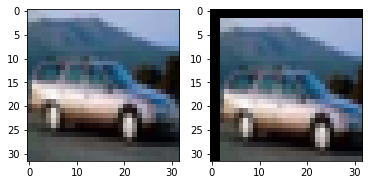

In [6]:
import matplotlib.pyplot as plt

trainX, trainY, testX, testY = load_dataset(SET_CIFAR)

f, ax = plt.subplots(1,2)

tmp = translate(trainX, 2,2)

ax[0].imshow(trainX[0])
ax[1].imshow(tmp[0])

In [7]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
if LEARN_MODEL:
  input_shape = trainX.shape[1:]
  print(input_shape)
  model = None
  model = resnet_v2(input_shape, 56, 2)
  print(trainY.shape)
  model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
  model.summary()
  model.fit(trainX, trainY, validation_data=(testX, testY)) # original paper 128
  scores = model.evaluate(testX, testY)
  print('Test loss; ', scores[0])
  print('Test accuracy; ', scores[1])

  # model.save('model.h5')

(32, 32, 3)
(10000, 2)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_____________________________________________________________________

Train on 10000 samples, validate on 2000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step
Test loss;  1.069319574356079
Test accuracy;  0.8379999995231628


In [10]:
import sklearn 
import sklearn.linear_model
import sklearn.pipeline

clf = sklearn.linear_model.LogisticRegression(max_iter=1000)
newmodel = Model(model.inputs, model.layers[-2].output)
print("pass2")
clf.fit(newmodel.predict(trainX), trainY.argmax(1))
print("pass")
print(clf.score(newmodel.predict(testX), testY.argmax(1)))

pass2
pass
0.925


## Calculate Loss and Influence

In [11]:
import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

loss = np.zeros(trainX.shape[0])
print('#: ', trainX.shape[0])

for i in range(trainX.shape[0]):
    y = trainY.argmax(1)[i] 
    s = sigmoid(np.dot(newmodel.predict(trainX[i:i+1]), clf.coef_.T))
    loss[i] = -1 * (y*math.log(s)) + (1-y)*math.log(1-s)
    #loss[i] = (sigmoid(np.dot(newmodel.predict(trainX[i:i+1]), clf.coef_.T)) - trainY.argmax(1)[i]) ** 2

print(loss.shape)
print(loss)

#:  10000
(10000,)
[ 5.49437138e-01  5.49950702e-02 -2.76715856e-04 ... -2.06495563e-05
  1.45438465e+00  2.90589478e+00]


In [12]:
import numpy as np 
x = newmodel.predict(trainX)
s = np.zeros(x.shape[0])
for i in range(x.shape[0]):
  rx = x[i].reshape(256, -1)
  s[i] = sigmoid(np.dot(rx.T, clf.coef_.T).item())


ds = s*(1-s)
ds = np.diag(ds)
# print('ds shape', ds.shape)
n = x.shape[0]
print(x.T.shape, np.dot(ds,x).shape)
# print('x shape', x.shape, ds.shape)
hess = np.dot(x.T, np.dot(ds,x))


influence = np.zeros(n)
for i in range(n):  
  rx = x[i].reshape(256,-1)
  s[i] = sigmoid(np.dot(rx.T, clf.coef_.T).item())
  y = trainY.argmax(1)[i]
 
  gradient = np.dot(rx.T, (s[i] - y))
  influence[i] = np.dot(np.dot(gradient, np.linalg.inv(hess)), gradient.T)

# print('x', x.shape) # 10,000 x 256
# print('hess',hess.shape) # 256 x 256
# print('grad',gradient.shape) # 256 x 10,000

print(influence.shape)
print(influence)

# import matplotlib.pyplot
# matplotlib.pyplot.hist(influence, bins=100)

## --------done 

(256, 10000) (10000, 256)
(10000,)
[6.46167485e-02 1.45720809e-03 3.59456051e-08 ... 7.03846528e-10
 2.22157234e-01 3.22019343e-01]


## Data augmentation

In [13]:
# random 
from numpy import random
# print(influence[influence<0])

n_augment_points = 300
n_augment_points += 1
# sum_aug_score = np.sum(influence)
# print(sum_aug_score)

sum_aug_score = 0
prob = np.zeros(influence.shape[0])

for i in range(influence.shape[0]):
    sum_aug_score += influence[i]
    prob[i] = sum_aug_score
  
rnd_v = np.sort(random.rand(n_augment_points))
aug_x = trainX
aug_y = trainY
cnt = 0
for i in range(aug_x.shape[0]):
    print('random number"', rnd_v[cnt], '/', 'inf:', prob[i]/sum_aug_score)
    if (rnd_v[cnt] <= prob[i]/sum_aug_score) & (cnt < n_augment_points-1):
        aug_y = np.append(aug_y, trainY[i].reshape(1,2), axis=0)
        aug_x = np.append(aug_x, translate(trainX[i], 5,5).reshape(1,32,32,3), axis=0)
        cnt += 1
    print('cnt ',cnt,'/','i: ', i+1)

model.fit(aug_x, aug_y, validation_data=(testX, testY)) # original paper 128
scores = model.evaluate(testX, testY)
print('Test loss; ', scores[0])
print('Test accuracy; ', scores[1])

random number" 0.0024614593074211433 / inf: 9.046311172688594e-05
cnt  0 / i:  1
random number" 0.0024614593074211433 / inf: 9.25031954716077e-05
cnt  0 / i:  2
random number" 0.0024614593074211433 / inf: 9.250324579526777e-05
cnt  0 / i:  3
random number" 0.0024614593074211433 / inf: 9.250507990295628e-05
cnt  0 / i:  4
random number" 0.0024614593074211433 / inf: 0.00014815660240364661
cnt  0 / i:  5
random number" 0.0024614593074211433 / inf: 0.00014818988595509603
cnt  0 / i:  6
random number" 0.0024614593074211433 / inf: 0.0002255388595474704
cnt  0 / i:  7
random number" 0.0024614593074211433 / inf: 0.00022555693128991722
cnt  0 / i:  8
random number" 0.0024614593074211433 / inf: 0.0002472713892654745
cnt  0 / i:  9
random number" 0.0024614593074211433 / inf: 0.00024727325400490744
cnt  0 / i:  10
random number" 0.0024614593074211433 / inf: 0.0002765741213854457
cnt  0 / i:  11
random number" 0.0024614593074211433 / inf: 0.00027663325940436857
cnt  0 / i:  12
random number" 0.0024

C:\Anaconda3\lib\site-packages\imgaug\augmenters\base.py:38: SuspiciousMultiImageShapeWarning: You provided a numpy array of shape (32, 32, 3) as a multi-image augmentation input, which was interpreted as (N, H, W). The last dimension however has value 1 or 3, which indicates that you provided a single image with shape (H, W, C) instead. If that is the case, you should use e.g. augmenter(image=<your input>) or augment_image(<your input>) -- note the singular 'image' instead of 'imageS'. Otherwise your single input image will be interpreted as multiple images of shape (H, W) during augmentation.
  category=SuspiciousMultiImageShapeWarning)


0.01371096921742757
cnt  2 / i:  132
random number" 0.021545521500596077 / inf: 0.013710969278857699
cnt  2 / i:  133
random number" 0.021545521500596077 / inf: 0.014192723505923339
cnt  2 / i:  134
random number" 0.021545521500596077 / inf: 0.01419272350609203
cnt  2 / i:  135
random number" 0.021545521500596077 / inf: 0.014192723544525342
cnt  2 / i:  136
random number" 0.021545521500596077 / inf: 0.014192724650262058
cnt  2 / i:  137
random number" 0.021545521500596077 / inf: 0.014315402034882687
cnt  2 / i:  138
random number" 0.021545521500596077 / inf: 0.014315416434321158
cnt  2 / i:  139
random number" 0.021545521500596077 / inf: 0.014315481351769924
cnt  2 / i:  140
random number" 0.021545521500596077 / inf: 0.01431548533125295
cnt  2 / i:  141
random number" 0.021545521500596077 / inf: 0.014317882824871668
cnt  2 / i:  142
random number" 0.021545521500596077 / inf: 0.014317882848723557
cnt  2 / i:  143
random number" 0.021545521500596077 / inf: 0.014317883115614874
cnt  2 / i

cnt  5 / i:  287
random number" 0.02888894056778779 / inf: 0.026802171249517774
cnt  5 / i:  288
random number" 0.02888894056778779 / inf: 0.026827474918901282
cnt  5 / i:  289
random number" 0.02888894056778779 / inf: 0.026827474940614
cnt  5 / i:  290
random number" 0.02888894056778779 / inf: 0.026827474940851803
cnt  5 / i:  291
random number" 0.02888894056778779 / inf: 0.026827474940983788
cnt  5 / i:  292
random number" 0.02888894056778779 / inf: 0.026827474952682732
cnt  5 / i:  293
random number" 0.02888894056778779 / inf: 0.026828036008328584
cnt  5 / i:  294
random number" 0.02888894056778779 / inf: 0.026941080817457583
cnt  5 / i:  295
random number" 0.02888894056778779 / inf: 0.027055992949440555
cnt  5 / i:  296
random number" 0.02888894056778779 / inf: 0.02705742192523282
cnt  5 / i:  297
random number" 0.02888894056778779 / inf: 0.027057422056951493
cnt  5 / i:  298
random number" 0.02888894056778779 / inf: 0.0278809847429872
cnt  5 / i:  299
random number" 0.028888940567

cnt  10 / i:  420
random number" 0.041829409708298626 / inf: 0.04012174039801052
cnt  10 / i:  421
random number" 0.041829409708298626 / inf: 0.040124686684356384
cnt  10 / i:  422
random number" 0.041829409708298626 / inf: 0.040622949698665714
cnt  10 / i:  423
random number" 0.041829409708298626 / inf: 0.04062294969906339
cnt  10 / i:  424
random number" 0.041829409708298626 / inf: 0.04062294969937014
cnt  10 / i:  425
random number" 0.041829409708298626 / inf: 0.040622949777228336
cnt  10 / i:  426
random number" 0.041829409708298626 / inf: 0.040629128297153164
cnt  10 / i:  427
random number" 0.041829409708298626 / inf: 0.04065778875887005
cnt  10 / i:  428
random number" 0.041829409708298626 / inf: 0.04074255492762249
cnt  10 / i:  429
random number" 0.041829409708298626 / inf: 0.04074913886270937
cnt  10 / i:  430
random number" 0.041829409708298626 / inf: 0.041149015779820435
cnt  10 / i:  431
random number" 0.041829409708298626 / inf: 0.04114901579631348
cnt  10 / i:  432
rando

cnt  13 / i:  609
random number" 0.05931013684706821 / inf: 0.05499994476821823
cnt  13 / i:  610
random number" 0.05931013684706821 / inf: 0.05499994476956369
cnt  13 / i:  611
random number" 0.05931013684706821 / inf: 0.055144457311350356
cnt  13 / i:  612
random number" 0.05931013684706821 / inf: 0.05514445749829148
cnt  13 / i:  613
random number" 0.05931013684706821 / inf: 0.0551479090563745
cnt  13 / i:  614
random number" 0.05931013684706821 / inf: 0.05514791051099016
cnt  13 / i:  615
random number" 0.05931013684706821 / inf: 0.05514792131888216
cnt  13 / i:  616
random number" 0.05931013684706821 / inf: 0.05520344027903584
cnt  13 / i:  617
random number" 0.05931013684706821 / inf: 0.055203458647219324
cnt  13 / i:  618
random number" 0.05931013684706821 / inf: 0.05520520847740704
cnt  13 / i:  619
random number" 0.05931013684706821 / inf: 0.055205208613005555
cnt  13 / i:  620
random number" 0.05931013684706821 / inf: 0.05520520863575029
cnt  13 / i:  621
random number" 0.059

random number" 0.06344354648126893 / inf: 0.06319525184033378
cnt  17 / i:  724
random number" 0.06344354648126893 / inf: 0.06319525495551091
cnt  17 / i:  725
random number" 0.06344354648126893 / inf: 0.0631957498540615
cnt  17 / i:  726
random number" 0.06344354648126893 / inf: 0.06324045902973184
cnt  17 / i:  727
random number" 0.06344354648126893 / inf: 0.06324045905285038
cnt  17 / i:  728
random number" 0.06344354648126893 / inf: 0.0632404923370163
cnt  17 / i:  729
random number" 0.06344354648126893 / inf: 0.06324049237663128
cnt  17 / i:  730
random number" 0.06344354648126893 / inf: 0.06324049238999237
cnt  17 / i:  731
random number" 0.06344354648126893 / inf: 0.0632879274547137
cnt  17 / i:  732
random number" 0.06344354648126893 / inf: 0.06328797203802702
cnt  17 / i:  733
random number" 0.06344354648126893 / inf: 0.06329563357110786
cnt  17 / i:  734
random number" 0.06344354648126893 / inf: 0.06332022840778632
cnt  17 / i:  735
random number" 0.06344354648126893 / inf: 0

cnt  21 / i:  868
random number" 0.07997671333579892 / inf: 0.07946874330848828
cnt  21 / i:  869
random number" 0.07997671333579892 / inf: 0.07946874330849482
cnt  21 / i:  870
random number" 0.07997671333579892 / inf: 0.07946874667511694
cnt  21 / i:  871
random number" 0.07997671333579892 / inf: 0.07946874667516829
cnt  21 / i:  872
random number" 0.07997671333579892 / inf: 0.07975881391683134
cnt  21 / i:  873
random number" 0.07997671333579892 / inf: 0.07975988252905708
cnt  21 / i:  874
random number" 0.07997671333579892 / inf: 0.07975988263484453
cnt  21 / i:  875
random number" 0.07997671333579892 / inf: 0.07976002568663655
cnt  21 / i:  876
random number" 0.07997671333579892 / inf: 0.07976002752764533
cnt  21 / i:  877
random number" 0.07997671333579892 / inf: 0.07976002779461547
cnt  21 / i:  878
random number" 0.07997671333579892 / inf: 0.07976046372885771
cnt  21 / i:  879
random number" 0.07997671333579892 / inf: 0.07976046372889135
cnt  21 / i:  880
random number" 0.07997

random number" 0.10200918593837871 / inf: 0.1019485145868946
cnt  24 / i:  1083
random number" 0.10200918593837871 / inf: 0.10209548378728127
cnt  25 / i:  1084
random number" 0.10475247697722123 / inf: 0.10268696579772654
cnt  25 / i:  1085
random number" 0.10475247697722123 / inf: 0.10321356423281333
cnt  25 / i:  1086
random number" 0.10475247697722123 / inf: 0.1032138654928731
cnt  25 / i:  1087
random number" 0.10475247697722123 / inf: 0.10321386722590996
cnt  25 / i:  1088
random number" 0.10475247697722123 / inf: 0.10321386722591441
cnt  25 / i:  1089
random number" 0.10475247697722123 / inf: 0.10321386822545683
cnt  25 / i:  1090
random number" 0.10475247697722123 / inf: 0.1032138682254569
cnt  25 / i:  1091
random number" 0.10475247697722123 / inf: 0.10321386825421586
cnt  25 / i:  1092
random number" 0.10475247697722123 / inf: 0.10372660945677284
cnt  25 / i:  1093
random number" 0.10475247697722123 / inf: 0.1037266094577116
cnt  25 / i:  1094
random number" 0.104752476977221

cnt  28 / i:  1203
random number" 0.11263457443391256 / inf: 0.11252685034830637
cnt  28 / i:  1204
random number" 0.11263457443391256 / inf: 0.11265026544462346
cnt  29 / i:  1205
random number" 0.1187975678887373 / inf: 0.11265026544462774
cnt  29 / i:  1206
random number" 0.1187975678887373 / inf: 0.11265150121176189
cnt  29 / i:  1207
random number" 0.1187975678887373 / inf: 0.11265311993411779
cnt  29 / i:  1208
random number" 0.1187975678887373 / inf: 0.11265315806016135
cnt  29 / i:  1209
random number" 0.1187975678887373 / inf: 0.11319537726795012
cnt  29 / i:  1210
random number" 0.1187975678887373 / inf: 0.11319537726810792
cnt  29 / i:  1211
random number" 0.1187975678887373 / inf: 0.11352325933611204
cnt  29 / i:  1212
random number" 0.1187975678887373 / inf: 0.11352902919997951
cnt  29 / i:  1213
random number" 0.1187975678887373 / inf: 0.11353109696365819
cnt  29 / i:  1214
random number" 0.1187975678887373 / inf: 0.11353109712053885
cnt  29 / i:  1215
random number" 0.11

cnt  37 / i:  1331
random number" 0.1419502506938487 / inf: 0.13456286836382683
cnt  37 / i:  1332
random number" 0.1419502506938487 / inf: 0.13456286926748104
cnt  37 / i:  1333
random number" 0.1419502506938487 / inf: 0.13456362851688453
cnt  37 / i:  1334
random number" 0.1419502506938487 / inf: 0.13499066289247671
cnt  37 / i:  1335
random number" 0.1419502506938487 / inf: 0.13499066289247957
cnt  37 / i:  1336
random number" 0.1419502506938487 / inf: 0.13509881424920225
cnt  37 / i:  1337
random number" 0.1419502506938487 / inf: 0.1350988142696879
cnt  37 / i:  1338
random number" 0.1419502506938487 / inf: 0.1355084822939323
cnt  37 / i:  1339
random number" 0.1419502506938487 / inf: 0.13555476698328248
cnt  37 / i:  1340
random number" 0.1419502506938487 / inf: 0.13555476701140085
cnt  37 / i:  1341
random number" 0.1419502506938487 / inf: 0.13555476748954626
cnt  37 / i:  1342
random number" 0.1419502506938487 / inf: 0.13555476748955905
cnt  37 / i:  1343
random number" 0.141950

random number" 0.14929353136931922 / inf: 0.14728980874042166
cnt  42 / i:  1435
random number" 0.14929353136931922 / inf: 0.14728980874108408
cnt  42 / i:  1436
random number" 0.14929353136931922 / inf: 0.14760038441415305
cnt  42 / i:  1437
random number" 0.14929353136931922 / inf: 0.1477639973932254
cnt  42 / i:  1438
random number" 0.14929353136931922 / inf: 0.14776399757293207
cnt  42 / i:  1439
random number" 0.14929353136931922 / inf: 0.14776399785208197
cnt  42 / i:  1440
random number" 0.14929353136931922 / inf: 0.14776674052427913
cnt  42 / i:  1441
random number" 0.14929353136931922 / inf: 0.14776674086339098
cnt  42 / i:  1442
random number" 0.14929353136931922 / inf: 0.1477667518952877
cnt  42 / i:  1443
random number" 0.14929353136931922 / inf: 0.14776675190575242
cnt  42 / i:  1444
random number" 0.14929353136931922 / inf: 0.14824056169794506
cnt  42 / i:  1445
random number" 0.14929353136931922 / inf: 0.14824056913609857
cnt  42 / i:  1446
random number" 0.1492935313693

cnt  48 / i:  1548
random number" 0.1580994790339525 / inf: 0.15834927576306404
cnt  49 / i:  1549
random number" 0.15904429875343062 / inf: 0.15834927577641264
cnt  49 / i:  1550
random number" 0.15904429875343062 / inf: 0.1583492773793186
cnt  49 / i:  1551
random number" 0.15904429875343062 / inf: 0.15834927737985846
cnt  49 / i:  1552
random number" 0.15904429875343062 / inf: 0.15834927990928158
cnt  49 / i:  1553
random number" 0.15904429875343062 / inf: 0.1588932951941861
cnt  49 / i:  1554
random number" 0.15904429875343062 / inf: 0.1588936866326795
cnt  49 / i:  1555
random number" 0.15904429875343062 / inf: 0.15933446885269423
cnt  50 / i:  1556
random number" 0.16506223895020222 / inf: 0.15933446885269842
cnt  50 / i:  1557
random number" 0.16506223895020222 / inf: 0.15934772036570483
cnt  50 / i:  1558
random number" 0.16506223895020222 / inf: 0.15934772036843392
cnt  50 / i:  1559
random number" 0.16506223895020222 / inf: 0.16008899724543976
cnt  50 / i:  1560
random number

random number" 0.18034119704981488 / inf: 0.16964093604067124
cnt  52 / i:  1697
random number" 0.18034119704981488 / inf: 0.16964093604139013
cnt  52 / i:  1698
random number" 0.18034119704981488 / inf: 0.1696409360416415
cnt  52 / i:  1699
random number" 0.18034119704981488 / inf: 0.1696409362315049
cnt  52 / i:  1700
random number" 0.18034119704981488 / inf: 0.16964138504325948
cnt  52 / i:  1701
random number" 0.18034119704981488 / inf: 0.16964138505628268
cnt  52 / i:  1702
random number" 0.18034119704981488 / inf: 0.16967245553533888
cnt  52 / i:  1703
random number" 0.18034119704981488 / inf: 0.17066554389979086
cnt  52 / i:  1704
random number" 0.18034119704981488 / inf: 0.17066555703043249
cnt  52 / i:  1705
random number" 0.18034119704981488 / inf: 0.17066555703295128
cnt  52 / i:  1706
random number" 0.18034119704981488 / inf: 0.1707043492552548
cnt  52 / i:  1707
random number" 0.18034119704981488 / inf: 0.17070434926120948
cnt  52 / i:  1708
random number" 0.18034119704981

cnt  54 / i:  1815
random number" 0.18134610388306982 / inf: 0.18119115128203295
cnt  54 / i:  1816
random number" 0.18134610388306982 / inf: 0.18122732013507561
cnt  54 / i:  1817
random number" 0.18134610388306982 / inf: 0.18122732063700117
cnt  54 / i:  1818
random number" 0.18134610388306982 / inf: 0.18153390573230604
cnt  55 / i:  1819
random number" 0.18231985838093867 / inf: 0.1815430184353007
cnt  55 / i:  1820
random number" 0.18231985838093867 / inf: 0.18170358000127557
cnt  55 / i:  1821
random number" 0.18231985838093867 / inf: 0.18170359034627667
cnt  55 / i:  1822
random number" 0.18231985838093867 / inf: 0.18170359035347042
cnt  55 / i:  1823
random number" 0.18231985838093867 / inf: 0.18175431262692704
cnt  55 / i:  1824
random number" 0.18231985838093867 / inf: 0.1820595504426813
cnt  55 / i:  1825
random number" 0.18231985838093867 / inf: 0.18222656859200936
cnt  55 / i:  1826
random number" 0.18231985838093867 / inf: 0.1822265685931803
cnt  55 / i:  1827
random numbe

cnt  62 / i:  1976
random number" 0.200711600606705 / inf: 0.19880695233061527
cnt  62 / i:  1977
random number" 0.200711600606705 / inf: 0.19880880372402898
cnt  62 / i:  1978
random number" 0.200711600606705 / inf: 0.1989653479558062
cnt  62 / i:  1979
random number" 0.200711600606705 / inf: 0.19933193862113893
cnt  62 / i:  1980
random number" 0.200711600606705 / inf: 0.19933193865666346
cnt  62 / i:  1981
random number" 0.200711600606705 / inf: 0.19933193867235263
cnt  62 / i:  1982
random number" 0.200711600606705 / inf: 0.19933193867285853
cnt  62 / i:  1983
random number" 0.200711600606705 / inf: 0.1996328424874901
cnt  62 / i:  1984
random number" 0.200711600606705 / inf: 0.19963284249259278
cnt  62 / i:  1985
random number" 0.200711600606705 / inf: 0.19963298353141273
cnt  62 / i:  1986
random number" 0.200711600606705 / inf: 0.1997436989527581
cnt  62 / i:  1987
random number" 0.200711600606705 / inf: 0.20021969303959508
cnt  62 / i:  1988
random number" 0.200711600606705 / i

cnt  68 / i:  2113
random number" 0.2163728680848661 / inf: 0.21558114953631227
cnt  68 / i:  2114
random number" 0.2163728680848661 / inf: 0.2155811794257832
cnt  68 / i:  2115
random number" 0.2163728680848661 / inf: 0.21558117965004112
cnt  68 / i:  2116
random number" 0.2163728680848661 / inf: 0.21558117967090426
cnt  68 / i:  2117
random number" 0.2163728680848661 / inf: 0.21588473775200026
cnt  68 / i:  2118
random number" 0.2163728680848661 / inf: 0.2159192334166643
cnt  68 / i:  2119
random number" 0.2163728680848661 / inf: 0.21591923373353658
cnt  68 / i:  2120
random number" 0.2163728680848661 / inf: 0.21591923384547176
cnt  68 / i:  2121
random number" 0.2163728680848661 / inf: 0.21591923440324268
cnt  68 / i:  2122
random number" 0.2163728680848661 / inf: 0.21591923440739183
cnt  68 / i:  2123
random number" 0.2163728680848661 / inf: 0.21601651826782522
cnt  68 / i:  2124
random number" 0.2163728680848661 / inf: 0.21638994026431685
cnt  69 / i:  2125
random number" 0.218501

cnt  74 / i:  2231
random number" 0.23123350281686672 / inf: 0.23058168397488876
cnt  74 / i:  2232
random number" 0.23123350281686672 / inf: 0.2305816839772018
cnt  74 / i:  2233
random number" 0.23123350281686672 / inf: 0.23058168397742593
cnt  74 / i:  2234
random number" 0.23123350281686672 / inf: 0.23058168397779308
cnt  74 / i:  2235
random number" 0.23123350281686672 / inf: 0.23069824356052931
cnt  74 / i:  2236
random number" 0.23123350281686672 / inf: 0.23069824686985438
cnt  74 / i:  2237
random number" 0.23123350281686672 / inf: 0.23069824699748023
cnt  74 / i:  2238
random number" 0.23123350281686672 / inf: 0.23069824699928318
cnt  74 / i:  2239
random number" 0.23123350281686672 / inf: 0.2307077470778899
cnt  74 / i:  2240
random number" 0.23123350281686672 / inf: 0.23070774707789285
cnt  74 / i:  2241
random number" 0.23123350281686672 / inf: 0.2310809229177636
cnt  74 / i:  2242
random number" 0.23123350281686672 / inf: 0.2310809229177647
cnt  74 / i:  2243
random number

cnt  81 / i:  2403
random number" 0.24874055334997625 / inf: 0.24858545103940619
cnt  81 / i:  2404
random number" 0.24874055334997625 / inf: 0.24858757973183282
cnt  81 / i:  2405
random number" 0.24874055334997625 / inf: 0.24861350433639232
cnt  81 / i:  2406
random number" 0.24874055334997625 / inf: 0.24861350433809157
cnt  81 / i:  2407
random number" 0.24874055334997625 / inf: 0.24861352012148652
cnt  81 / i:  2408
random number" 0.24874055334997625 / inf: 0.24861352286752927
cnt  81 / i:  2409
random number" 0.24874055334997625 / inf: 0.2486135228894424
cnt  81 / i:  2410
random number" 0.24874055334997625 / inf: 0.24863015575136868
cnt  81 / i:  2411
random number" 0.24874055334997625 / inf: 0.24863015575272054
cnt  81 / i:  2412
random number" 0.24874055334997625 / inf: 0.2486311707334614
cnt  81 / i:  2413
random number" 0.24874055334997625 / inf: 0.2486311707350491
cnt  81 / i:  2414
random number" 0.24874055334997625 / inf: 0.24863123066531237
cnt  81 / i:  2415
random numbe

cnt  91 / i:  2525
random number" 0.2688067272518113 / inf: 0.2649862187661013
cnt  91 / i:  2526
random number" 0.2688067272518113 / inf: 0.2649862190646525
cnt  91 / i:  2527
random number" 0.2688067272518113 / inf: 0.26499199495579095
cnt  91 / i:  2528
random number" 0.2688067272518113 / inf: 0.26499199573571325
cnt  91 / i:  2529
random number" 0.2688067272518113 / inf: 0.2650184846987902
cnt  91 / i:  2530
random number" 0.2688067272518113 / inf: 0.2650186145857337
cnt  91 / i:  2531
random number" 0.2688067272518113 / inf: 0.2657028397203178
cnt  91 / i:  2532
random number" 0.2688067272518113 / inf: 0.26582337241800214
cnt  91 / i:  2533
random number" 0.2688067272518113 / inf: 0.2658244757954705
cnt  91 / i:  2534
random number" 0.2688067272518113 / inf: 0.2658270597778611
cnt  91 / i:  2535
random number" 0.2688067272518113 / inf: 0.26582705985161736
cnt  91 / i:  2536
random number" 0.2688067272518113 / inf: 0.2658533607935112
cnt  91 / i:  2537
random number" 0.268806727251

cnt  94 / i:  2703
random number" 0.28667209312380104 / inf: 0.28437656825656693
cnt  94 / i:  2704
random number" 0.28667209312380104 / inf: 0.28438311482638684
cnt  94 / i:  2705
random number" 0.28667209312380104 / inf: 0.2844770276945508
cnt  94 / i:  2706
random number" 0.28667209312380104 / inf: 0.28447773361553963
cnt  94 / i:  2707
random number" 0.28667209312380104 / inf: 0.28448138730579287
cnt  94 / i:  2708
random number" 0.28667209312380104 / inf: 0.2846445764342264
cnt  94 / i:  2709
random number" 0.28667209312380104 / inf: 0.28464458477358934
cnt  94 / i:  2710
random number" 0.28667209312380104 / inf: 0.2851624938739676
cnt  94 / i:  2711
random number" 0.28667209312380104 / inf: 0.28516250236362944
cnt  94 / i:  2712
random number" 0.28667209312380104 / inf: 0.285162502489885
cnt  94 / i:  2713
random number" 0.28667209312380104 / inf: 0.2851625025094522
cnt  94 / i:  2714
random number" 0.28667209312380104 / inf: 0.2851625035344783
cnt  94 / i:  2715
random number" 0

cnt  99 / i:  2827
random number" 0.2947428060601558 / inf: 0.29490053839102703
cnt  100 / i:  2828
random number" 0.29822971756006034 / inf: 0.2949005441916736
cnt  100 / i:  2829
random number" 0.29822971756006034 / inf: 0.29523115312130216
cnt  100 / i:  2830
random number" 0.29822971756006034 / inf: 0.2957522131646412
cnt  100 / i:  2831
random number" 0.29822971756006034 / inf: 0.29575221334131363
cnt  100 / i:  2832
random number" 0.29822971756006034 / inf: 0.29614096779013244
cnt  100 / i:  2833
random number" 0.29822971756006034 / inf: 0.29614096961438685
cnt  100 / i:  2834
random number" 0.29822971756006034 / inf: 0.29614096961901565
cnt  100 / i:  2835
random number" 0.29822971756006034 / inf: 0.29615063944365694
cnt  100 / i:  2836
random number" 0.29822971756006034 / inf: 0.2968509973209744
cnt  100 / i:  2837
random number" 0.29822971756006034 / inf: 0.29685099736194526
cnt  100 / i:  2838
random number" 0.29822971756006034 / inf: 0.2970063013894839
cnt  100 / i:  2839
ra

cnt  104 / i:  2945
random number" 0.311495257368979 / inf: 0.3059999927031436
cnt  104 / i:  2946
random number" 0.311495257368979 / inf: 0.3063727487743353
cnt  104 / i:  2947
random number" 0.311495257368979 / inf: 0.30637275045620593
cnt  104 / i:  2948
random number" 0.311495257368979 / inf: 0.30696133618954446
cnt  104 / i:  2949
random number" 0.311495257368979 / inf: 0.306962659667209
cnt  104 / i:  2950
random number" 0.311495257368979 / inf: 0.3069626940651256
cnt  104 / i:  2951
random number" 0.311495257368979 / inf: 0.30696269406681226
cnt  104 / i:  2952
random number" 0.311495257368979 / inf: 0.30696269412675997
cnt  104 / i:  2953
random number" 0.311495257368979 / inf: 0.30696269412735927
cnt  104 / i:  2954
random number" 0.311495257368979 / inf: 0.30784562830910306
cnt  104 / i:  2955
random number" 0.311495257368979 / inf: 0.30784562830993834
cnt  104 / i:  2956
random number" 0.311495257368979 / inf: 0.3078456299753084
cnt  104 / i:  2957
random number" 0.311495257

cnt  112 / i:  3162
random number" 0.3394571536143869 / inf: 0.33158238913403276
cnt  112 / i:  3163
random number" 0.3394571536143869 / inf: 0.3316722725391414
cnt  112 / i:  3164
random number" 0.3394571536143869 / inf: 0.3318397262036874
cnt  112 / i:  3165
random number" 0.3394571536143869 / inf: 0.33239904882985244
cnt  112 / i:  3166
random number" 0.3394571536143869 / inf: 0.33239904884855
cnt  112 / i:  3167
random number" 0.3394571536143869 / inf: 0.3323990493330622
cnt  112 / i:  3168
random number" 0.3394571536143869 / inf: 0.3326938785084612
cnt  112 / i:  3169
random number" 0.3394571536143869 / inf: 0.3326938785085308
cnt  112 / i:  3170
random number" 0.3394571536143869 / inf: 0.3326938795790031
cnt  112 / i:  3171
random number" 0.3394571536143869 / inf: 0.33319225825319626
cnt  112 / i:  3172
random number" 0.3394571536143869 / inf: 0.33319225830363663
cnt  112 / i:  3173
random number" 0.3394571536143869 / inf: 0.333192258304685
cnt  112 / i:  3174
random number" 0.33

cnt  116 / i:  3330
random number" 0.34706105227057404 / inf: 0.3459088861142409
cnt  116 / i:  3331
random number" 0.34706105227057404 / inf: 0.34590888763780614
cnt  116 / i:  3332
random number" 0.34706105227057404 / inf: 0.346339796731173
cnt  116 / i:  3333
random number" 0.34706105227057404 / inf: 0.346731820157111
cnt  116 / i:  3334
random number" 0.34706105227057404 / inf: 0.34673182015713566
cnt  116 / i:  3335
random number" 0.34706105227057404 / inf: 0.34673182222634036
cnt  116 / i:  3336
random number" 0.34706105227057404 / inf: 0.3470839750196755
cnt  117 / i:  3337
random number" 0.3475578586317676 / inf: 0.3470842411637521
cnt  117 / i:  3338
random number" 0.3475578586317676 / inf: 0.34708431773595205
cnt  117 / i:  3339
random number" 0.3475578586317676 / inf: 0.3474226912939119
cnt  117 / i:  3340
random number" 0.3475578586317676 / inf: 0.34742269327530595
cnt  117 / i:  3341
random number" 0.3475578586317676 / inf: 0.34742300038539264
cnt  117 / i:  3342
random nu

cnt  121 / i:  3437
random number" 0.3617684912628245 / inf: 0.3569457805433861
cnt  121 / i:  3438
random number" 0.3617684912628245 / inf: 0.3569457811028682
cnt  121 / i:  3439
random number" 0.3617684912628245 / inf: 0.3570392235395953
cnt  121 / i:  3440
random number" 0.3617684912628245 / inf: 0.35703925078591137
cnt  121 / i:  3441
random number" 0.3617684912628245 / inf: 0.3570445679260749
cnt  121 / i:  3442
random number" 0.3617684912628245 / inf: 0.35704456838014886
cnt  121 / i:  3443
random number" 0.3617684912628245 / inf: 0.35704456838658244
cnt  121 / i:  3444
random number" 0.3617684912628245 / inf: 0.3573979782873173
cnt  121 / i:  3445
random number" 0.3617684912628245 / inf: 0.3573979782880821
cnt  121 / i:  3446
random number" 0.3617684912628245 / inf: 0.35739797829869036
cnt  121 / i:  3447
random number" 0.3617684912628245 / inf: 0.3573980460723955
cnt  121 / i:  3448
random number" 0.3617684912628245 / inf: 0.35739882750533003
cnt  121 / i:  3449
random number" 

random number" 0.3728708837601409 / inf: 0.3719234323327833
cnt  125 / i:  3607
random number" 0.3728708837601409 / inf: 0.37202143498521273
cnt  125 / i:  3608
random number" 0.3728708837601409 / inf: 0.3720215033378998
cnt  125 / i:  3609
random number" 0.3728708837601409 / inf: 0.3720215116221807
cnt  125 / i:  3610
random number" 0.3728708837601409 / inf: 0.37202151304775594
cnt  125 / i:  3611
random number" 0.3728708837601409 / inf: 0.37202151442042536
cnt  125 / i:  3612
random number" 0.3728708837601409 / inf: 0.3720215144204349
cnt  125 / i:  3613
random number" 0.3728708837601409 / inf: 0.3725690555134797
cnt  125 / i:  3614
random number" 0.3728708837601409 / inf: 0.3725692580708301
cnt  125 / i:  3615
random number" 0.3728708837601409 / inf: 0.37256925807083174
cnt  125 / i:  3616
random number" 0.3728708837601409 / inf: 0.3725832895016908
cnt  125 / i:  3617
random number" 0.3728708837601409 / inf: 0.373150125448479
cnt  126 / i:  3618
random number" 0.38268432585935963 / 

random number" 0.39605146166743943 / inf: 0.3889666894709476
cnt  128 / i:  3782
random number" 0.39605146166743943 / inf: 0.3889666897281449
cnt  128 / i:  3783
random number" 0.39605146166743943 / inf: 0.38896668974374826
cnt  128 / i:  3784
random number" 0.39605146166743943 / inf: 0.38916271921059514
cnt  128 / i:  3785
random number" 0.39605146166743943 / inf: 0.38916271925376317
cnt  128 / i:  3786
random number" 0.39605146166743943 / inf: 0.3891692941760819
cnt  128 / i:  3787
random number" 0.39605146166743943 / inf: 0.38924632784036
cnt  128 / i:  3788
random number" 0.39605146166743943 / inf: 0.38934309680350127
cnt  128 / i:  3789
random number" 0.39605146166743943 / inf: 0.3893430968116704
cnt  128 / i:  3790
random number" 0.39605146166743943 / inf: 0.38934309682314416
cnt  128 / i:  3791
random number" 0.39605146166743943 / inf: 0.38934309682314755
cnt  128 / i:  3792
random number" 0.39605146166743943 / inf: 0.389343742178965
cnt  128 / i:  3793
random number" 0.39605146

cnt  131 / i:  3923
random number" 0.41465263004838016 / inf: 0.40531379597763295
cnt  131 / i:  3924
random number" 0.41465263004838016 / inf: 0.40534041341179605
cnt  131 / i:  3925
random number" 0.41465263004838016 / inf: 0.40551778187292575
cnt  131 / i:  3926
random number" 0.41465263004838016 / inf: 0.4059833048271475
cnt  131 / i:  3927
random number" 0.41465263004838016 / inf: 0.40598330526388576
cnt  131 / i:  3928
random number" 0.41465263004838016 / inf: 0.4059911934564236
cnt  131 / i:  3929
random number" 0.41465263004838016 / inf: 0.4060294150698352
cnt  131 / i:  3930
random number" 0.41465263004838016 / inf: 0.40610810706078876
cnt  131 / i:  3931
random number" 0.41465263004838016 / inf: 0.40610810706079253
cnt  131 / i:  3932
random number" 0.41465263004838016 / inf: 0.40610810719109186
cnt  131 / i:  3933
random number" 0.41465263004838016 / inf: 0.4061106234852444
cnt  131 / i:  3934
random number" 0.41465263004838016 / inf: 0.40611062436027967
cnt  131 / i:  3935


cnt  131 / i:  4027
random number" 0.41465263004838016 / inf: 0.4130689575359105
cnt  131 / i:  4028
random number" 0.41465263004838016 / inf: 0.4130689757242563
cnt  131 / i:  4029
random number" 0.41465263004838016 / inf: 0.4136004046602431
cnt  131 / i:  4030
random number" 0.41465263004838016 / inf: 0.4136004056622968
cnt  131 / i:  4031
random number" 0.41465263004838016 / inf: 0.4138780360617731
cnt  131 / i:  4032
random number" 0.41465263004838016 / inf: 0.4138780500784942
cnt  131 / i:  4033
random number" 0.41465263004838016 / inf: 0.4140114221965753
cnt  131 / i:  4034
random number" 0.41465263004838016 / inf: 0.41401142219731
cnt  131 / i:  4035
random number" 0.41465263004838016 / inf: 0.41404379452971973
cnt  131 / i:  4036
random number" 0.41465263004838016 / inf: 0.4140477863681871
cnt  131 / i:  4037
random number" 0.41465263004838016 / inf: 0.41404778637866496
cnt  131 / i:  4038
random number" 0.41465263004838016 / inf: 0.41411371076511316
cnt  131 / i:  4039
random 

random number" 0.4310133343967124 / inf: 0.42429324633431303
cnt  134 / i:  4156
random number" 0.4310133343967124 / inf: 0.4242932463345508
cnt  134 / i:  4157
random number" 0.4310133343967124 / inf: 0.42430266933611044
cnt  134 / i:  4158
random number" 0.4310133343967124 / inf: 0.424302669422254
cnt  134 / i:  4159
random number" 0.4310133343967124 / inf: 0.42431440265412973
cnt  134 / i:  4160
random number" 0.4310133343967124 / inf: 0.4243144028277663
cnt  134 / i:  4161
random number" 0.4310133343967124 / inf: 0.4243144029182644
cnt  134 / i:  4162
random number" 0.4310133343967124 / inf: 0.42431440296256334
cnt  134 / i:  4163
random number" 0.4310133343967124 / inf: 0.42431440432163364
cnt  134 / i:  4164
random number" 0.4310133343967124 / inf: 0.4243238624090206
cnt  134 / i:  4165
random number" 0.4310133343967124 / inf: 0.4243409273961034
cnt  134 / i:  4166
random number" 0.4310133343967124 / inf: 0.4247726919772134
cnt  134 / i:  4167
random number" 0.4310133343967124 / 

cnt  136 / i:  4293
random number" 0.43527522677508734 / inf: 0.4343577015401737
cnt  136 / i:  4294
random number" 0.43527522677508734 / inf: 0.43530834977932115
cnt  137 / i:  4295
random number" 0.4358646768620572 / inf: 0.4354313965306998
cnt  137 / i:  4296
random number" 0.4358646768620572 / inf: 0.4354342724238585
cnt  137 / i:  4297
random number" 0.4358646768620572 / inf: 0.43543849601330864
cnt  137 / i:  4298
random number" 0.4358646768620572 / inf: 0.4354384960343456
cnt  137 / i:  4299
random number" 0.4358646768620572 / inf: 0.4354384960354168
cnt  137 / i:  4300
random number" 0.4358646768620572 / inf: 0.43543849715441246
cnt  137 / i:  4301
random number" 0.4358646768620572 / inf: 0.43546990073750974
cnt  137 / i:  4302
random number" 0.4358646768620572 / inf: 0.43546990075388914
cnt  137 / i:  4303
random number" 0.4358646768620572 / inf: 0.4354699024454907
cnt  137 / i:  4304
random number" 0.4358646768620572 / inf: 0.4354870483488635
cnt  137 / i:  4305
random number

random number" 0.45260111848487006 / inf: 0.45243979259377226
cnt  141 / i:  4483
random number" 0.45260111848487006 / inf: 0.45244088893479445
cnt  141 / i:  4484
random number" 0.45260111848487006 / inf: 0.45252246446537525
cnt  141 / i:  4485
random number" 0.45260111848487006 / inf: 0.45255175419450777
cnt  141 / i:  4486
random number" 0.45260111848487006 / inf: 0.45255335263528046
cnt  141 / i:  4487
random number" 0.45260111848487006 / inf: 0.45321719095020446
cnt  142 / i:  4488
random number" 0.453152937212119 / inf: 0.4532421935243
cnt  143 / i:  4489
random number" 0.45344897110872706 / inf: 0.4532939828107552
cnt  143 / i:  4490
random number" 0.45344897110872706 / inf: 0.45329398281083044
cnt  143 / i:  4491
random number" 0.45344897110872706 / inf: 0.4532940590516239
cnt  143 / i:  4492
random number" 0.45344897110872706 / inf: 0.4532940595432767
cnt  143 / i:  4493
random number" 0.45344897110872706 / inf: 0.4533266760726253
cnt  143 / i:  4494
random number" 0.453448971

cnt  147 / i:  4586
random number" 0.4700824048164236 / inf: 0.46171550057519556
cnt  147 / i:  4587
random number" 0.4700824048164236 / inf: 0.46171560479590434
cnt  147 / i:  4588
random number" 0.4700824048164236 / inf: 0.4626578500942966
cnt  147 / i:  4589
random number" 0.4700824048164236 / inf: 0.46265785009430516
cnt  147 / i:  4590
random number" 0.4700824048164236 / inf: 0.46265785009541904
cnt  147 / i:  4591
random number" 0.4700824048164236 / inf: 0.4626578507783043
cnt  147 / i:  4592
random number" 0.4700824048164236 / inf: 0.4628471912130132
cnt  147 / i:  4593
random number" 0.4700824048164236 / inf: 0.4628479882654894
cnt  147 / i:  4594
random number" 0.4700824048164236 / inf: 0.4628479882654952
cnt  147 / i:  4595
random number" 0.4700824048164236 / inf: 0.4628483677040668
cnt  147 / i:  4596
random number" 0.4700824048164236 / inf: 0.46284836778955346
cnt  147 / i:  4597
random number" 0.4700824048164236 / inf: 0.4628493125114956
cnt  147 / i:  4598
random number" 

random number" 0.4791970250645854 / inf: 0.47862046397730607
cnt  148 / i:  4750
random number" 0.4791970250645854 / inf: 0.4786204700902369
cnt  148 / i:  4751
random number" 0.4791970250645854 / inf: 0.4786488284891946
cnt  148 / i:  4752
random number" 0.4791970250645854 / inf: 0.47877061942689186
cnt  148 / i:  4753
random number" 0.4791970250645854 / inf: 0.4787706195082743
cnt  148 / i:  4754
random number" 0.4791970250645854 / inf: 0.47877062202760956
cnt  148 / i:  4755
random number" 0.4791970250645854 / inf: 0.4787706220280341
cnt  148 / i:  4756
random number" 0.4791970250645854 / inf: 0.4787706220280453
cnt  148 / i:  4757
random number" 0.4791970250645854 / inf: 0.4787707776471518
cnt  148 / i:  4758
random number" 0.4791970250645854 / inf: 0.4787707777266982
cnt  148 / i:  4759
random number" 0.4791970250645854 / inf: 0.47877077772750776
cnt  148 / i:  4760
random number" 0.4791970250645854 / inf: 0.4787709975417202
cnt  148 / i:  4761
random number" 0.4791970250645854 / 

cnt  152 / i:  4899
random number" 0.4953507167318518 / inf: 0.49037965776345926
cnt  152 / i:  4900
random number" 0.4953507167318518 / inf: 0.4903796577662026
cnt  152 / i:  4901
random number" 0.4953507167318518 / inf: 0.49037985226995634
cnt  152 / i:  4902
random number" 0.4953507167318518 / inf: 0.49037985254300165
cnt  152 / i:  4903
random number" 0.4953507167318518 / inf: 0.49037985258744726
cnt  152 / i:  4904
random number" 0.4953507167318518 / inf: 0.4903798531987634
cnt  152 / i:  4905
random number" 0.4953507167318518 / inf: 0.49089383797870734
cnt  152 / i:  4906
random number" 0.4953507167318518 / inf: 0.490893837979436
cnt  152 / i:  4907
random number" 0.4953507167318518 / inf: 0.49089422741237987
cnt  152 / i:  4908
random number" 0.4953507167318518 / inf: 0.49130291477450044
cnt  152 / i:  4909
random number" 0.4953507167318518 / inf: 0.4913029148652966
cnt  152 / i:  4910
random number" 0.4953507167318518 / inf: 0.49133201462931275
cnt  152 / i:  4911
random number

cnt  155 / i:  5099
random number" 0.5083772286862682 / inf: 0.5054203454479487
cnt  155 / i:  5100
random number" 0.5083772286862682 / inf: 0.5054203470150999
cnt  155 / i:  5101
random number" 0.5083772286862682 / inf: 0.5054203470510158
cnt  155 / i:  5102
random number" 0.5083772286862682 / inf: 0.5056486851508728
cnt  155 / i:  5103
random number" 0.5083772286862682 / inf: 0.5056486934673636
cnt  155 / i:  5104
random number" 0.5083772286862682 / inf: 0.5058165095137458
cnt  155 / i:  5105
random number" 0.5083772286862682 / inf: 0.5058165095177123
cnt  155 / i:  5106
random number" 0.5083772286862682 / inf: 0.5058165095177829
cnt  155 / i:  5107
random number" 0.5083772286862682 / inf: 0.5058258538129587
cnt  155 / i:  5108
random number" 0.5083772286862682 / inf: 0.5058258851785885
cnt  155 / i:  5109
random number" 0.5083772286862682 / inf: 0.5058260320834751
cnt  155 / i:  5110
random number" 0.5083772286862682 / inf: 0.5059507670884921
cnt  155 / i:  5111
random number" 0.508

random number" 0.5221833984492118 / inf: 0.5191977001536123
cnt  158 / i:  5278
random number" 0.5221833984492118 / inf: 0.5191977009121604
cnt  158 / i:  5279
random number" 0.5221833984492118 / inf: 0.5191977009796425
cnt  158 / i:  5280
random number" 0.5221833984492118 / inf: 0.5191978934444076
cnt  158 / i:  5281
random number" 0.5221833984492118 / inf: 0.5192262273288201
cnt  158 / i:  5282
random number" 0.5221833984492118 / inf: 0.5192263471062067
cnt  158 / i:  5283
random number" 0.5221833984492118 / inf: 0.5193438960333651
cnt  158 / i:  5284
random number" 0.5221833984492118 / inf: 0.519344062494222
cnt  158 / i:  5285
random number" 0.5221833984492118 / inf: 0.5195186668030118
cnt  158 / i:  5286
random number" 0.5221833984492118 / inf: 0.5195186668030451
cnt  158 / i:  5287
random number" 0.5221833984492118 / inf: 0.519523046022181
cnt  158 / i:  5288
random number" 0.5221833984492118 / inf: 0.5195239742022008
cnt  158 / i:  5289
random number" 0.5221833984492118 / inf: 0

cnt  162 / i:  5382
random number" 0.5341957018133863 / inf: 0.5324603582529478
cnt  162 / i:  5383
random number" 0.5341957018133863 / inf: 0.5324603583605304
cnt  162 / i:  5384
random number" 0.5341957018133863 / inf: 0.5333412263394411
cnt  162 / i:  5385
random number" 0.5341957018133863 / inf: 0.5333471439923699
cnt  162 / i:  5386
random number" 0.5341957018133863 / inf: 0.533386585322605
cnt  162 / i:  5387
random number" 0.5341957018133863 / inf: 0.5334120922939143
cnt  162 / i:  5388
random number" 0.5341957018133863 / inf: 0.5334120923948495
cnt  162 / i:  5389
random number" 0.5341957018133863 / inf: 0.5334536850286241
cnt  162 / i:  5390
random number" 0.5341957018133863 / inf: 0.5339871369308167
cnt  162 / i:  5391
random number" 0.5341957018133863 / inf: 0.5339871369311856
cnt  162 / i:  5392
random number" 0.5341957018133863 / inf: 0.5339872514131766
cnt  162 / i:  5393
random number" 0.5341957018133863 / inf: 0.5339875460812668
cnt  162 / i:  5394
random number" 0.5341

random number" 0.5515029902215194 / inf: 0.547185151769144
cnt  168 / i:  5503
random number" 0.5515029902215194 / inf: 0.5474742211618842
cnt  168 / i:  5504
random number" 0.5515029902215194 / inf: 0.5475399388091088
cnt  168 / i:  5505
random number" 0.5515029902215194 / inf: 0.5475399389117875
cnt  168 / i:  5506
random number" 0.5515029902215194 / inf: 0.5475463430350531
cnt  168 / i:  5507
random number" 0.5515029902215194 / inf: 0.5476434806050308
cnt  168 / i:  5508
random number" 0.5515029902215194 / inf: 0.5479121198378455
cnt  168 / i:  5509
random number" 0.5515029902215194 / inf: 0.5483292050549813
cnt  168 / i:  5510
random number" 0.5515029902215194 / inf: 0.5483292050551826
cnt  168 / i:  5511
random number" 0.5515029902215194 / inf: 0.548329209488065
cnt  168 / i:  5512
random number" 0.5515029902215194 / inf: 0.548364807959661
cnt  168 / i:  5513
random number" 0.5515029902215194 / inf: 0.5483648079682168
cnt  168 / i:  5514
random number" 0.5515029902215194 / inf: 0.

random number" 0.5669849512045778 / inf: 0.5636045268781845
cnt  172 / i:  5648
random number" 0.5669849512045778 / inf: 0.5636045268802269
cnt  172 / i:  5649
random number" 0.5669849512045778 / inf: 0.5636045268803309
cnt  172 / i:  5650
random number" 0.5669849512045778 / inf: 0.5636045827066286
cnt  172 / i:  5651
random number" 0.5669849512045778 / inf: 0.5636336232619487
cnt  172 / i:  5652
random number" 0.5669849512045778 / inf: 0.5636336236027137
cnt  172 / i:  5653
random number" 0.5669849512045778 / inf: 0.5636336501784621
cnt  172 / i:  5654
random number" 0.5669849512045778 / inf: 0.5636336858857885
cnt  172 / i:  5655
random number" 0.5669849512045778 / inf: 0.5644277826453231
cnt  172 / i:  5656
random number" 0.5669849512045778 / inf: 0.5651504010453192
cnt  172 / i:  5657
random number" 0.5669849512045778 / inf: 0.5651520511447271
cnt  172 / i:  5658
random number" 0.5669849512045778 / inf: 0.5651520518727877
cnt  172 / i:  5659
random number" 0.5669849512045778 / inf:

cnt  173 / i:  5829
random number" 0.584136785455127 / inf: 0.5840720037513397
cnt  173 / i:  5830
random number" 0.584136785455127 / inf: 0.5840720804038968
cnt  173 / i:  5831
random number" 0.584136785455127 / inf: 0.5844772069469603
cnt  174 / i:  5832
random number" 0.5869708394130865 / inf: 0.5844844810754365
cnt  174 / i:  5833
random number" 0.5869708394130865 / inf: 0.5850114394133101
cnt  174 / i:  5834
random number" 0.5869708394130865 / inf: 0.5850152340303472
cnt  174 / i:  5835
random number" 0.5869708394130865 / inf: 0.585015234063265
cnt  174 / i:  5836
random number" 0.5869708394130865 / inf: 0.5850152341207369
cnt  174 / i:  5837
random number" 0.5869708394130865 / inf: 0.5850157598440126
cnt  174 / i:  5838
random number" 0.5869708394130865 / inf: 0.5850295149954052
cnt  174 / i:  5839
random number" 0.5869708394130865 / inf: 0.585029571331623
cnt  174 / i:  5840
random number" 0.5869708394130865 / inf: 0.5850355147482466
cnt  174 / i:  5841
random number" 0.58697083

cnt  178 / i:  5951
random number" 0.5971699175873215 / inf: 0.5958197304546136
cnt  178 / i:  5952
random number" 0.5971699175873215 / inf: 0.5958197304546361
cnt  178 / i:  5953
random number" 0.5971699175873215 / inf: 0.5958206113671138
cnt  178 / i:  5954
random number" 0.5971699175873215 / inf: 0.5958206114199571
cnt  178 / i:  5955
random number" 0.5971699175873215 / inf: 0.5958730479458414
cnt  178 / i:  5956
random number" 0.5971699175873215 / inf: 0.5958730656681166
cnt  178 / i:  5957
random number" 0.5971699175873215 / inf: 0.596094423079203
cnt  178 / i:  5958
random number" 0.5971699175873215 / inf: 0.596105411484279
cnt  178 / i:  5959
random number" 0.5971699175873215 / inf: 0.5961054114845082
cnt  178 / i:  5960
random number" 0.5971699175873215 / inf: 0.5963832454200513
cnt  178 / i:  5961
random number" 0.5971699175873215 / inf: 0.5966874727131348
cnt  178 / i:  5962
random number" 0.5971699175873215 / inf: 0.5966893865971578
cnt  178 / i:  5963
random number" 0.59716

cnt  188 / i:  6141
random number" 0.620288927309246 / inf: 0.6185760672724284
cnt  188 / i:  6142
random number" 0.620288927309246 / inf: 0.6187144865898823
cnt  188 / i:  6143
random number" 0.620288927309246 / inf: 0.6187144865901999
cnt  188 / i:  6144
random number" 0.620288927309246 / inf: 0.6187152685171065
cnt  188 / i:  6145
random number" 0.620288927309246 / inf: 0.619297096566804
cnt  188 / i:  6146
random number" 0.620288927309246 / inf: 0.6195827975120882
cnt  188 / i:  6147
random number" 0.620288927309246 / inf: 0.6195828052260932
cnt  188 / i:  6148
random number" 0.620288927309246 / inf: 0.6200970108257486
cnt  188 / i:  6149
random number" 0.620288927309246 / inf: 0.6200970583748849
cnt  188 / i:  6150
random number" 0.620288927309246 / inf: 0.6200970585330943
cnt  188 / i:  6151
random number" 0.620288927309246 / inf: 0.6200970630418369
cnt  188 / i:  6152
random number" 0.620288927309246 / inf: 0.6201063322848425
cnt  188 / i:  6153
random number" 0.620288927309246 

cnt  197 / i:  6251
random number" 0.6363686001296598 / inf: 0.6352299464445542
cnt  197 / i:  6252
random number" 0.6363686001296598 / inf: 0.6352299481348651
cnt  197 / i:  6253
random number" 0.6363686001296598 / inf: 0.63563119137712
cnt  197 / i:  6254
random number" 0.6363686001296598 / inf: 0.6356311913856902
cnt  197 / i:  6255
random number" 0.6363686001296598 / inf: 0.635631191534329
cnt  197 / i:  6256
random number" 0.6363686001296598 / inf: 0.6359904839793098
cnt  197 / i:  6257
random number" 0.6363686001296598 / inf: 0.6359915931991366
cnt  197 / i:  6258
random number" 0.6363686001296598 / inf: 0.6360041937729461
cnt  197 / i:  6259
random number" 0.6363686001296598 / inf: 0.6364403135855512
cnt  198 / i:  6260
random number" 0.636539580716646 / inf: 0.636909269794048
cnt  199 / i:  6261
random number" 0.6401441213457488 / inf: 0.6369096352554651
cnt  199 / i:  6262
random number" 0.6401441213457488 / inf: 0.6369096352590313
cnt  199 / i:  6263
random number" 0.64014412

random number" 0.6608898357711762 / inf: 0.6533826057737222
cnt  201 / i:  6413
random number" 0.6608898357711762 / inf: 0.6533826078849126
cnt  201 / i:  6414
random number" 0.6608898357711762 / inf: 0.6533826078882389
cnt  201 / i:  6415
random number" 0.6608898357711762 / inf: 0.6539870426073349
cnt  201 / i:  6416
random number" 0.6608898357711762 / inf: 0.6539870432315199
cnt  201 / i:  6417
random number" 0.6608898357711762 / inf: 0.6539870441210474
cnt  201 / i:  6418
random number" 0.6608898357711762 / inf: 0.6542754103108738
cnt  201 / i:  6419
random number" 0.6608898357711762 / inf: 0.6542754103109992
cnt  201 / i:  6420
random number" 0.6608898357711762 / inf: 0.6542754105156622
cnt  201 / i:  6421
random number" 0.6608898357711762 / inf: 0.6542754105925336
cnt  201 / i:  6422
random number" 0.6608898357711762 / inf: 0.6543296239975629
cnt  201 / i:  6423
random number" 0.6608898357711762 / inf: 0.654329633916609
cnt  201 / i:  6424
random number" 0.6608898357711762 / inf: 

random number" 0.6659773330207244 / inf: 0.6623720140298328
cnt  202 / i:  6540
random number" 0.6659773330207244 / inf: 0.6623720140324403
cnt  202 / i:  6541
random number" 0.6659773330207244 / inf: 0.6623720212933989
cnt  202 / i:  6542
random number" 0.6659773330207244 / inf: 0.6623720226417138
cnt  202 / i:  6543
random number" 0.6659773330207244 / inf: 0.6628240567824433
cnt  202 / i:  6544
random number" 0.6659773330207244 / inf: 0.6628240568139896
cnt  202 / i:  6545
random number" 0.6659773330207244 / inf: 0.6628243442553595
cnt  202 / i:  6546
random number" 0.6659773330207244 / inf: 0.6632412244078493
cnt  202 / i:  6547
random number" 0.6659773330207244 / inf: 0.663241224407996
cnt  202 / i:  6548
random number" 0.6659773330207244 / inf: 0.6632412627197285
cnt  202 / i:  6549
random number" 0.6659773330207244 / inf: 0.6637981012333581
cnt  202 / i:  6550
random number" 0.6659773330207244 / inf: 0.6637981027892911
cnt  202 / i:  6551
random number" 0.6659773330207244 / inf: 

cnt  205 / i:  6656
random number" 0.6794515177276379 / inf: 0.6754590427870334
cnt  205 / i:  6657
random number" 0.6794515177276379 / inf: 0.6754591676260318
cnt  205 / i:  6658
random number" 0.6794515177276379 / inf: 0.6754591676260905
cnt  205 / i:  6659
random number" 0.6794515177276379 / inf: 0.675459178340593
cnt  205 / i:  6660
random number" 0.6794515177276379 / inf: 0.675459178342564
cnt  205 / i:  6661
random number" 0.6794515177276379 / inf: 0.675460609504144
cnt  205 / i:  6662
random number" 0.6794515177276379 / inf: 0.6754654879042673
cnt  205 / i:  6663
random number" 0.6794515177276379 / inf: 0.6754654879042894
cnt  205 / i:  6664
random number" 0.6794515177276379 / inf: 0.6754654879056393
cnt  205 / i:  6665
random number" 0.6794515177276379 / inf: 0.6754654879056812
cnt  205 / i:  6666
random number" 0.6794515177276379 / inf: 0.6754654879585207
cnt  205 / i:  6667
random number" 0.6794515177276379 / inf: 0.6754654879717155
cnt  205 / i:  6668
random number" 0.679451

random number" 0.6976747274742356 / inf: 0.6854011278095441
cnt  208 / i:  6777
random number" 0.6976747274742356 / inf: 0.6860833112534884
cnt  208 / i:  6778
random number" 0.6976747274742356 / inf: 0.6861086709508185
cnt  208 / i:  6779
random number" 0.6976747274742356 / inf: 0.686284947393996
cnt  208 / i:  6780
random number" 0.6976747274742356 / inf: 0.6862905927303208
cnt  208 / i:  6781
random number" 0.6976747274742356 / inf: 0.6866318509712275
cnt  208 / i:  6782
random number" 0.6976747274742356 / inf: 0.6866369103374966
cnt  208 / i:  6783
random number" 0.6976747274742356 / inf: 0.6866369103730823
cnt  208 / i:  6784
random number" 0.6976747274742356 / inf: 0.6872141255367626
cnt  208 / i:  6785
random number" 0.6976747274742356 / inf: 0.6876065314103164
cnt  208 / i:  6786
random number" 0.6976747274742356 / inf: 0.6876065314330251
cnt  208 / i:  6787
random number" 0.6976747274742356 / inf: 0.6878960080505395
cnt  208 / i:  6788
random number" 0.6976747274742356 / inf: 

cnt  209 / i:  6888
random number" 0.7047737338395709 / inf: 0.6981292705053966
cnt  209 / i:  6889
random number" 0.7047737338395709 / inf: 0.6981325248411968
cnt  209 / i:  6890
random number" 0.7047737338395709 / inf: 0.6981703918820622
cnt  209 / i:  6891
random number" 0.7047737338395709 / inf: 0.6981703919806047
cnt  209 / i:  6892
random number" 0.7047737338395709 / inf: 0.6981711392835309
cnt  209 / i:  6893
random number" 0.7047737338395709 / inf: 0.6987840078020214
cnt  209 / i:  6894
random number" 0.7047737338395709 / inf: 0.6987840078526881
cnt  209 / i:  6895
random number" 0.7047737338395709 / inf: 0.698784009918587
cnt  209 / i:  6896
random number" 0.7047737338395709 / inf: 0.6988019308774426
cnt  209 / i:  6897
random number" 0.7047737338395709 / inf: 0.6988020373879242
cnt  209 / i:  6898
random number" 0.7047737338395709 / inf: 0.6988020374787546
cnt  209 / i:  6899
random number" 0.7047737338395709 / inf: 0.6989797232315025
cnt  209 / i:  6900
random number" 0.7047

random number" 0.7142003128774043 / inf: 0.7113932954308598
cnt  211 / i:  7023
random number" 0.7142003128774043 / inf: 0.7113932955759622
cnt  211 / i:  7024
random number" 0.7142003128774043 / inf: 0.7113935253487607
cnt  211 / i:  7025
random number" 0.7142003128774043 / inf: 0.71139360621713
cnt  211 / i:  7026
random number" 0.7142003128774043 / inf: 0.7114058883265926
cnt  211 / i:  7027
random number" 0.7142003128774043 / inf: 0.7117873082481185
cnt  211 / i:  7028
random number" 0.7142003128774043 / inf: 0.7117873951424277
cnt  211 / i:  7029
random number" 0.7142003128774043 / inf: 0.7119218138987407
cnt  211 / i:  7030
random number" 0.7142003128774043 / inf: 0.7119219949592552
cnt  211 / i:  7031
random number" 0.7142003128774043 / inf: 0.7121985687149669
cnt  211 / i:  7032
random number" 0.7142003128774043 / inf: 0.7122629752554918
cnt  211 / i:  7033
random number" 0.7142003128774043 / inf: 0.7126160715818393
cnt  211 / i:  7034
random number" 0.7142003128774043 / inf: 0

cnt  214 / i:  7142
random number" 0.7239414927059494 / inf: 0.7215310366964232
cnt  214 / i:  7143
random number" 0.7239414927059494 / inf: 0.7215310559739588
cnt  214 / i:  7144
random number" 0.7239414927059494 / inf: 0.7215310559740539
cnt  214 / i:  7145
random number" 0.7239414927059494 / inf: 0.7215766081163305
cnt  214 / i:  7146
random number" 0.7239414927059494 / inf: 0.7215939005690691
cnt  214 / i:  7147
random number" 0.7239414927059494 / inf: 0.7216212769170106
cnt  214 / i:  7148
random number" 0.7239414927059494 / inf: 0.7216212769244369
cnt  214 / i:  7149
random number" 0.7239414927059494 / inf: 0.721621276972213
cnt  214 / i:  7150
random number" 0.7239414927059494 / inf: 0.7216212769776313
cnt  214 / i:  7151
random number" 0.7239414927059494 / inf: 0.7218624793288709
cnt  214 / i:  7152
random number" 0.7239414927059494 / inf: 0.7219779108407671
cnt  214 / i:  7153
random number" 0.7239414927059494 / inf: 0.7219783810228866
cnt  214 / i:  7154
random number" 0.7239

cnt  220 / i:  7293
random number" 0.7368086147697392 / inf: 0.736406447915236
cnt  220 / i:  7294
random number" 0.7368086147697392 / inf: 0.7364064656248813
cnt  220 / i:  7295
random number" 0.7368086147697392 / inf: 0.7364106762132445
cnt  220 / i:  7296
random number" 0.7368086147697392 / inf: 0.736410676315893
cnt  220 / i:  7297
random number" 0.7368086147697392 / inf: 0.7364106806665539
cnt  220 / i:  7298
random number" 0.7368086147697392 / inf: 0.736416155652872
cnt  220 / i:  7299
random number" 0.7368086147697392 / inf: 0.736508965730207
cnt  220 / i:  7300
random number" 0.7368086147697392 / inf: 0.7365089657304361
cnt  220 / i:  7301
random number" 0.7368086147697392 / inf: 0.736508965730464
cnt  220 / i:  7302
random number" 0.7368086147697392 / inf: 0.7365089657526187
cnt  220 / i:  7303
random number" 0.7368086147697392 / inf: 0.7365089657541317
cnt  220 / i:  7304
random number" 0.7368086147697392 / inf: 0.7365089657779523
cnt  220 / i:  7305
random number" 0.73680861

random number" 0.7618170237874166 / inf: 0.7564443644411374
cnt  228 / i:  7479
random number" 0.7618170237874166 / inf: 0.756444364441145
cnt  228 / i:  7480
random number" 0.7618170237874166 / inf: 0.7570252514073013
cnt  228 / i:  7481
random number" 0.7618170237874166 / inf: 0.7573094208965008
cnt  228 / i:  7482
random number" 0.7618170237874166 / inf: 0.757760628792883
cnt  228 / i:  7483
random number" 0.7618170237874166 / inf: 0.7577606711096075
cnt  228 / i:  7484
random number" 0.7618170237874166 / inf: 0.7577671330179283
cnt  228 / i:  7485
random number" 0.7618170237874166 / inf: 0.7577671330660504
cnt  228 / i:  7486
random number" 0.7618170237874166 / inf: 0.7579065824141977
cnt  228 / i:  7487
random number" 0.7618170237874166 / inf: 0.7581003140574654
cnt  228 / i:  7488
random number" 0.7618170237874166 / inf: 0.7582842372847063
cnt  228 / i:  7489
random number" 0.7618170237874166 / inf: 0.7582842373889791
cnt  228 / i:  7490
random number" 0.7618170237874166 / inf: 0

cnt  232 / i:  7649
random number" 0.7722303888841936 / inf: 0.771145547190066
cnt  232 / i:  7650
random number" 0.7722303888841936 / inf: 0.7713539671191925
cnt  232 / i:  7651
random number" 0.7722303888841936 / inf: 0.7713539671200773
cnt  232 / i:  7652
random number" 0.7722303888841936 / inf: 0.7713539690589585
cnt  232 / i:  7653
random number" 0.7722303888841936 / inf: 0.7713539700218224
cnt  232 / i:  7654
random number" 0.7722303888841936 / inf: 0.7713539700233131
cnt  232 / i:  7655
random number" 0.7722303888841936 / inf: 0.7713544878702331
cnt  232 / i:  7656
random number" 0.7722303888841936 / inf: 0.7713544902457018
cnt  232 / i:  7657
random number" 0.7722303888841936 / inf: 0.7713544903132001
cnt  232 / i:  7658
random number" 0.7722303888841936 / inf: 0.7714615542622698
cnt  232 / i:  7659
random number" 0.7722303888841936 / inf: 0.771993079263093
cnt  232 / i:  7660
random number" 0.7722303888841936 / inf: 0.7720019013544932
cnt  232 / i:  7661
random number" 0.77223

cnt  237 / i:  7798
random number" 0.7841583669761142 / inf: 0.7840484572982453
cnt  237 / i:  7799
random number" 0.7841583669761142 / inf: 0.7840484810032798
cnt  237 / i:  7800
random number" 0.7841583669761142 / inf: 0.7840484820833343
cnt  237 / i:  7801
random number" 0.7841583669761142 / inf: 0.7843107027324969
cnt  238 / i:  7802
random number" 0.7842744287735077 / inf: 0.7843107027384494
cnt  239 / i:  7803
random number" 0.7866468437688656 / inf: 0.7843273640292702
cnt  239 / i:  7804
random number" 0.7866468437688656 / inf: 0.7843273640363748
cnt  239 / i:  7805
random number" 0.7866468437688656 / inf: 0.7843273667936482
cnt  239 / i:  7806
random number" 0.7866468437688656 / inf: 0.7843273667936889
cnt  239 / i:  7807
random number" 0.7866468437688656 / inf: 0.7843273668030039
cnt  239 / i:  7808
random number" 0.7866468437688656 / inf: 0.7847124867742753
cnt  239 / i:  7809
random number" 0.7866468437688656 / inf: 0.7847126719389997
cnt  239 / i:  7810
random number" 0.786

cnt  243 / i:  7918
random number" 0.803921312635235 / inf: 0.7966047068962532
cnt  243 / i:  7919
random number" 0.803921312635235 / inf: 0.7966047148205815
cnt  243 / i:  7920
random number" 0.803921312635235 / inf: 0.7966047148260453
cnt  243 / i:  7921
random number" 0.803921312635235 / inf: 0.796605459897638
cnt  243 / i:  7922
random number" 0.803921312635235 / inf: 0.797411630819079
cnt  243 / i:  7923
random number" 0.803921312635235 / inf: 0.7974116317679167
cnt  243 / i:  7924
random number" 0.803921312635235 / inf: 0.7974116317768449
cnt  243 / i:  7925
random number" 0.803921312635235 / inf: 0.797907394500667
cnt  243 / i:  7926
random number" 0.803921312635235 / inf: 0.7979073945124755
cnt  243 / i:  7927
random number" 0.803921312635235 / inf: 0.7982013936375859
cnt  243 / i:  7928
random number" 0.803921312635235 / inf: 0.7982646962576673
cnt  243 / i:  7929
random number" 0.803921312635235 / inf: 0.7983493810287788
cnt  243 / i:  7930
random number" 0.803921312635235 / 

cnt  248 / i:  8042
random number" 0.8139333071597428 / inf: 0.8120183883966766
cnt  248 / i:  8043
random number" 0.8139333071597428 / inf: 0.8120184318718777
cnt  248 / i:  8044
random number" 0.8139333071597428 / inf: 0.8120186358333533
cnt  248 / i:  8045
random number" 0.8139333071597428 / inf: 0.8131900995591854
cnt  248 / i:  8046
random number" 0.8139333071597428 / inf: 0.8132160754860717
cnt  248 / i:  8047
random number" 0.8139333071597428 / inf: 0.8132160755327292
cnt  248 / i:  8048
random number" 0.8139333071597428 / inf: 0.8136576468182283
cnt  248 / i:  8049
random number" 0.8139333071597428 / inf: 0.8136838916194393
cnt  248 / i:  8050
random number" 0.8139333071597428 / inf: 0.8136847476208693
cnt  248 / i:  8051
random number" 0.8139333071597428 / inf: 0.8144766298865952
cnt  249 / i:  8052
random number" 0.8159000403731864 / inf: 0.8149146494671587
cnt  249 / i:  8053
random number" 0.8159000403731864 / inf: 0.8149146494780223
cnt  249 / i:  8054
random number" 0.815

cnt  253 / i:  8170
random number" 0.8262472208520857 / inf: 0.8256874246577951
cnt  253 / i:  8171
random number" 0.8262472208520857 / inf: 0.8263189897933672
cnt  254 / i:  8172
random number" 0.82776668150445 / inf: 0.8265774172611835
cnt  254 / i:  8173
random number" 0.82776668150445 / inf: 0.8271436997591249
cnt  254 / i:  8174
random number" 0.82776668150445 / inf: 0.8271436998323028
cnt  254 / i:  8175
random number" 0.82776668150445 / inf: 0.8275381272675751
cnt  254 / i:  8176
random number" 0.82776668150445 / inf: 0.8275381272707122
cnt  254 / i:  8177
random number" 0.82776668150445 / inf: 0.8275946875620229
cnt  254 / i:  8178
random number" 0.82776668150445 / inf: 0.8275946876890268
cnt  254 / i:  8179
random number" 0.82776668150445 / inf: 0.8275946876891176
cnt  254 / i:  8180
random number" 0.82776668150445 / inf: 0.8275946881598264
cnt  254 / i:  8181
random number" 0.82776668150445 / inf: 0.8276386734523851
cnt  254 / i:  8182
random number" 0.82776668150445 / inf: 0

cnt  258 / i:  8291
random number" 0.838918512823304 / inf: 0.8386764295406022
cnt  258 / i:  8292
random number" 0.838918512823304 / inf: 0.83890031239387
cnt  258 / i:  8293
random number" 0.838918512823304 / inf: 0.8389003123938705
cnt  258 / i:  8294
random number" 0.838918512823304 / inf: 0.8389012690224176
cnt  258 / i:  8295
random number" 0.838918512823304 / inf: 0.8390865713850538
cnt  259 / i:  8296
random number" 0.8453999723155988 / inf: 0.8390867191594796
cnt  259 / i:  8297
random number" 0.8453999723155988 / inf: 0.8391240958361924
cnt  259 / i:  8298
random number" 0.8453999723155988 / inf: 0.8391240968549148
cnt  259 / i:  8299
random number" 0.8453999723155988 / inf: 0.8391240968611839
cnt  259 / i:  8300
random number" 0.8453999723155988 / inf: 0.8391240968618312
cnt  259 / i:  8301
random number" 0.8453999723155988 / inf: 0.839155604940493
cnt  259 / i:  8302
random number" 0.8453999723155988 / inf: 0.8391556049407033
cnt  259 / i:  8303
random number" 0.84539997231

cnt  262 / i:  8461
random number" 0.8564867755100847 / inf: 0.8542210877632761
cnt  262 / i:  8462
random number" 0.8564867755100847 / inf: 0.8542210877633128
cnt  262 / i:  8463
random number" 0.8564867755100847 / inf: 0.8542210956873222
cnt  262 / i:  8464
random number" 0.8564867755100847 / inf: 0.854221095688295
cnt  262 / i:  8465
random number" 0.8564867755100847 / inf: 0.854221095692417
cnt  262 / i:  8466
random number" 0.8564867755100847 / inf: 0.8542210957558423
cnt  262 / i:  8467
random number" 0.8564867755100847 / inf: 0.8542235682676252
cnt  262 / i:  8468
random number" 0.8564867755100847 / inf: 0.8542235682693965
cnt  262 / i:  8469
random number" 0.8564867755100847 / inf: 0.8542235682711451
cnt  262 / i:  8470
random number" 0.8564867755100847 / inf: 0.8543380622490379
cnt  262 / i:  8471
random number" 0.8564867755100847 / inf: 0.8548040683945821
cnt  262 / i:  8472
random number" 0.8564867755100847 / inf: 0.8551263247000338
cnt  262 / i:  8473
random number" 0.85648

random number" 0.8675795162250238 / inf: 0.8657826047482193
cnt  266 / i:  8588
random number" 0.8675795162250238 / inf: 0.8670506083773745
cnt  266 / i:  8589
random number" 0.8675795162250238 / inf: 0.8670506084216919
cnt  266 / i:  8590
random number" 0.8675795162250238 / inf: 0.8670506084424687
cnt  266 / i:  8591
random number" 0.8675795162250238 / inf: 0.8670506084425412
cnt  266 / i:  8592
random number" 0.8675795162250238 / inf: 0.8676018787367703
cnt  267 / i:  8593
random number" 0.8875854329663346 / inf: 0.8676018788206693
cnt  267 / i:  8594
random number" 0.8875854329663346 / inf: 0.8676216832114771
cnt  267 / i:  8595
random number" 0.8875854329663346 / inf: 0.8681378526222926
cnt  267 / i:  8596
random number" 0.8875854329663346 / inf: 0.8681378526226651
cnt  267 / i:  8597
random number" 0.8875854329663346 / inf: 0.8681378526228062
cnt  267 / i:  8598
random number" 0.8875854329663346 / inf: 0.8681413676059863
cnt  267 / i:  8599
random number" 0.8875854329663346 / inf:

cnt  268 / i:  8783
random number" 0.8885273889458926 / inf: 0.887837232419323
cnt  268 / i:  8784
random number" 0.8885273889458926 / inf: 0.8878372324193581
cnt  268 / i:  8785
random number" 0.8885273889458926 / inf: 0.8878372590679504
cnt  268 / i:  8786
random number" 0.8885273889458926 / inf: 0.8878648609539775
cnt  268 / i:  8787
random number" 0.8885273889458926 / inf: 0.8878648610061642
cnt  268 / i:  8788
random number" 0.8885273889458926 / inf: 0.887864861006677
cnt  268 / i:  8789
random number" 0.8885273889458926 / inf: 0.887864863535955
cnt  268 / i:  8790
random number" 0.8885273889458926 / inf: 0.8878648635361324
cnt  268 / i:  8791
random number" 0.8885273889458926 / inf: 0.8878648635363763
cnt  268 / i:  8792
random number" 0.8885273889458926 / inf: 0.8878648638268579
cnt  268 / i:  8793
random number" 0.8885273889458926 / inf: 0.8878982883205984
cnt  268 / i:  8794
random number" 0.8885273889458926 / inf: 0.8878982883616405
cnt  268 / i:  8795
random number" 0.888527

cnt  272 / i:  8899
random number" 0.9000507028956225 / inf: 0.8982990444841213
cnt  272 / i:  8900
random number" 0.9000507028956225 / inf: 0.8982990444842877
cnt  272 / i:  8901
random number" 0.9000507028956225 / inf: 0.8982990445262016
cnt  272 / i:  8902
random number" 0.9000507028956225 / inf: 0.8991256406365448
cnt  272 / i:  8903
random number" 0.9000507028956225 / inf: 0.8991256407424502
cnt  272 / i:  8904
random number" 0.9000507028956225 / inf: 0.8991446688976842
cnt  272 / i:  8905
random number" 0.9000507028956225 / inf: 0.899174269208852
cnt  272 / i:  8906
random number" 0.9000507028956225 / inf: 0.8998424922533479
cnt  272 / i:  8907
random number" 0.9000507028956225 / inf: 0.8998438124816763
cnt  272 / i:  8908
random number" 0.9000507028956225 / inf: 0.9001529378014724
cnt  273 / i:  8909
random number" 0.9006631731425605 / inf: 0.9001529457840223
cnt  273 / i:  8910
random number" 0.9006631731425605 / inf: 0.9003408906702363
cnt  273 / i:  8911
random number" 0.9006

random number" 0.9088380218935693 / inf: 0.9084714601621112
cnt  277 / i:  9008
random number" 0.9088380218935693 / inf: 0.9084771835928145
cnt  277 / i:  9009
random number" 0.9088380218935693 / inf: 0.9088766185293283
cnt  278 / i:  9010
random number" 0.9125352649985423 / inf: 0.9088766185293427
cnt  278 / i:  9011
random number" 0.9125352649985423 / inf: 0.9088766185499108
cnt  278 / i:  9012
random number" 0.9125352649985423 / inf: 0.9088766185586852
cnt  278 / i:  9013
random number" 0.9125352649985423 / inf: 0.9092463788205942
cnt  278 / i:  9014
random number" 0.9125352649985423 / inf: 0.9092463789276672
cnt  278 / i:  9015
random number" 0.9125352649985423 / inf: 0.9093833241034316
cnt  278 / i:  9016
random number" 0.9125352649985423 / inf: 0.909715003387976
cnt  278 / i:  9017
random number" 0.9125352649985423 / inf: 0.9097150133127937
cnt  278 / i:  9018
random number" 0.9125352649985423 / inf: 0.9097301190293972
cnt  278 / i:  9019
random number" 0.9125352649985423 / inf: 

cnt  281 / i:  9125
random number" 0.9259441311923555 / inf: 0.9169731239956568
cnt  281 / i:  9126
random number" 0.9259441311923555 / inf: 0.9169731239962413
cnt  281 / i:  9127
random number" 0.9259441311923555 / inf: 0.9175437190197073
cnt  281 / i:  9128
random number" 0.9259441311923555 / inf: 0.9175437190275236
cnt  281 / i:  9129
random number" 0.9259441311923555 / inf: 0.9177477594961249
cnt  281 / i:  9130
random number" 0.9259441311923555 / inf: 0.917784360052731
cnt  281 / i:  9131
random number" 0.9259441311923555 / inf: 0.9177857009214375
cnt  281 / i:  9132
random number" 0.9259441311923555 / inf: 0.918344448459086
cnt  281 / i:  9133
random number" 0.9259441311923555 / inf: 0.9183444490082355
cnt  281 / i:  9134
random number" 0.9259441311923555 / inf: 0.9183490331185183
cnt  281 / i:  9135
random number" 0.9259441311923555 / inf: 0.9187988159844558
cnt  281 / i:  9136
random number" 0.9259441311923555 / inf: 0.9187988191619434
cnt  281 / i:  9137
random number" 0.92594

cnt  285 / i:  9258
random number" 0.9344009275975653 / inf: 0.9318309796253569
cnt  285 / i:  9259
random number" 0.9344009275975653 / inf: 0.9320627405109808
cnt  285 / i:  9260
random number" 0.9344009275975653 / inf: 0.9320939476092701
cnt  285 / i:  9261
random number" 0.9344009275975653 / inf: 0.9320939703855171
cnt  285 / i:  9262
random number" 0.9344009275975653 / inf: 0.9327100725001949
cnt  285 / i:  9263
random number" 0.9344009275975653 / inf: 0.9327109323838613
cnt  285 / i:  9264
random number" 0.9344009275975653 / inf: 0.9330141031133101
cnt  285 / i:  9265
random number" 0.9344009275975653 / inf: 0.9330141031134275
cnt  285 / i:  9266
random number" 0.9344009275975653 / inf: 0.9330141031135228
cnt  285 / i:  9267
random number" 0.9344009275975653 / inf: 0.9330141851826677
cnt  285 / i:  9268
random number" 0.9344009275975653 / inf: 0.9330144946309472
cnt  285 / i:  9269
random number" 0.9344009275975653 / inf: 0.9330155624950217
cnt  285 / i:  9270
random number" 0.934

cnt  289 / i:  9364
random number" 0.9423525646627612 / inf: 0.9420461807898014
cnt  289 / i:  9365
random number" 0.9423525646627612 / inf: 0.942046232196003
cnt  289 / i:  9366
random number" 0.9423525646627612 / inf: 0.9425144589323019
cnt  290 / i:  9367
random number" 0.9577080826679963 / inf: 0.9425148638401719
cnt  290 / i:  9368
random number" 0.9577080826679963 / inf: 0.942797780510768
cnt  290 / i:  9369
random number" 0.9577080826679963 / inf: 0.9429701499190243
cnt  290 / i:  9370
random number" 0.9577080826679963 / inf: 0.9431815973119626
cnt  290 / i:  9371
random number" 0.9577080826679963 / inf: 0.94318159731254
cnt  290 / i:  9372
random number" 0.9577080826679963 / inf: 0.9431815973367734
cnt  290 / i:  9373
random number" 0.9577080826679963 / inf: 0.9431815984851463
cnt  290 / i:  9374
random number" 0.9577080826679963 / inf: 0.9431815984862324
cnt  290 / i:  9375
random number" 0.9577080826679963 / inf: 0.9438055811419809
cnt  290 / i:  9376
random number" 0.9577080

random number" 0.9577080826679963 / inf: 0.9572577190646311
cnt  290 / i:  9564
random number" 0.9577080826679963 / inf: 0.957282898088167
cnt  290 / i:  9565
random number" 0.9577080826679963 / inf: 0.9572829148363006
cnt  290 / i:  9566
random number" 0.9577080826679963 / inf: 0.9572836512328108
cnt  290 / i:  9567
random number" 0.9577080826679963 / inf: 0.957283653373373
cnt  290 / i:  9568
random number" 0.9577080826679963 / inf: 0.9572836535957692
cnt  290 / i:  9569
random number" 0.9577080826679963 / inf: 0.9573025257374342
cnt  290 / i:  9570
random number" 0.9577080826679963 / inf: 0.9573025264485949
cnt  290 / i:  9571
random number" 0.9577080826679963 / inf: 0.9573281569328976
cnt  290 / i:  9572
random number" 0.9577080826679963 / inf: 0.9573877662985164
cnt  290 / i:  9573
random number" 0.9577080826679963 / inf: 0.957387786377733
cnt  290 / i:  9574
random number" 0.9577080826679963 / inf: 0.9573878002189865
cnt  290 / i:  9575
random number" 0.9577080826679963 / inf: 0.

cnt  293 / i:  9692
random number" 0.9702761972055414 / inf: 0.9698428899761941
cnt  293 / i:  9693
random number" 0.9702761972055414 / inf: 0.9698428899854513
cnt  293 / i:  9694
random number" 0.9702761972055414 / inf: 0.9698428900702442
cnt  293 / i:  9695
random number" 0.9702761972055414 / inf: 0.9698428900834316
cnt  293 / i:  9696
random number" 0.9702761972055414 / inf: 0.969842890185459
cnt  293 / i:  9697
random number" 0.9702761972055414 / inf: 0.9698497757235528
cnt  293 / i:  9698
random number" 0.9702761972055414 / inf: 0.9698497757873937
cnt  293 / i:  9699
random number" 0.9702761972055414 / inf: 0.9698497757877172
cnt  293 / i:  9700
random number" 0.9702761972055414 / inf: 0.9708224966314478
cnt  294 / i:  9701
random number" 0.975838820337483 / inf: 0.9708224970980528
cnt  294 / i:  9702
random number" 0.975838820337483 / inf: 0.9708224970984357
cnt  294 / i:  9703
random number" 0.975838820337483 / inf: 0.9714428508888487
cnt  294 / i:  9704
random number" 0.9758388

cnt  297 / i:  9834
random number" 0.9826938953137941 / inf: 0.9813821541823253
cnt  297 / i:  9835
random number" 0.9826938953137941 / inf: 0.9813821541852832
cnt  297 / i:  9836
random number" 0.9826938953137941 / inf: 0.9813822007338794
cnt  297 / i:  9837
random number" 0.9826938953137941 / inf: 0.9814164764144365
cnt  297 / i:  9838
random number" 0.9826938953137941 / inf: 0.9815105546604639
cnt  297 / i:  9839
random number" 0.9826938953137941 / inf: 0.9815275408866897
cnt  297 / i:  9840
random number" 0.9826938953137941 / inf: 0.98152889995271
cnt  297 / i:  9841
random number" 0.9826938953137941 / inf: 0.9815289137646834
cnt  297 / i:  9842
random number" 0.9826938953137941 / inf: 0.9815295935285427
cnt  297 / i:  9843
random number" 0.9826938953137941 / inf: 0.9815295935286084
cnt  297 / i:  9844
random number" 0.9826938953137941 / inf: 0.9815295935811263
cnt  297 / i:  9845
random number" 0.9826938953137941 / inf: 0.9815295936297475
cnt  297 / i:  9846
random number" 0.98269

2000/2000 [==============================] - 16s 8ms/step
Test loss;  0.8447786536216736
Test accuracy;  0.840499997138977


In [14]:
import sklearn 
import sklearn.linear_model
import sklearn.pipeline

clf = sklearn.linear_model.LogisticRegression(max_iter=1000)
newmodel = Model(model.inputs, model.layers[-2].output)
print("pass2")
clf.fit(newmodel.predict(aug_x), aug_y.argmax(1))
print("pass")
print(clf.score(newmodel.predict(testX), testY.argmax(1)))

pass2
pass
0.942


### Deterministic Prop.

In [15]:
# plotting the graphs
from numpy import random
# print(influence[influence<0])

loss = np.zeros(15)
accuracy = np.zeros(15)
min_loss = 100
max_loss = 0
min_acc = 100
max_acc = 0
averaging_factor = 10
for a in range(averaging_factor): #For getting minimum, max and average
  for k in range(15): #For different augmentation values
    n_augment_points = 0
    if(k < 6):
      n_augment_points = k * 10
    else:
      n_augment_points = k * 50
    n_augment_points += 1
    # sum_aug_score = np.sum(influence)
    # print(sum_aug_score)
      
    aug_x = trainX
    aug_y = trainY
    cnt = 0
    for i in range(aug_x.shape[0]):
      #print('random number"', rnd_v[cnt], '/', 'inf:', prob[i]/sum_aug_score)
      if (influence[i] > 0.70) & (cnt < n_augment_points-1):
        aug_y = np.append(aug_y, trainY[i].reshape(1,2), axis=0)
        aug_x = np.append(aug_x, translate(trainX[i], 5,5).reshape(1,32,32,3), axis=0)
        cnt += 1
      #print('cnt ',cnt,'/','i: ', i+1)

    model.fit(aug_x, aug_y, validation_data=(testX, testY)) # original paper 128
    scores = model.evaluate(testX, testY)
    #print('Test loss; ', scores[0])
    #print('Test accuracy; ', scores[1])
    loss[k] += scores[0]
    accuracy[k] += scores[1]
    min_loss = min(min_loss, scores[0])
    max_loss = max(max_loss, scores[0])
    min_acc = min(min_acc, scores[1])
    max_acc = max(max_acc, scores[1])

loss /= averaging_factor
accuracy /= averaging_factor

print(min_loss, max_loss, loss)
print(min_acc, max_acc, accuracy)

Train on 10000 samples, validate on 2000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step


C:\Anaconda3\lib\site-packages\imgaug\augmenters\base.py:38: SuspiciousMultiImageShapeWarning: You provided a numpy array of shape (32, 32, 3) as a multi-image augmentation input, which was interpreted as (N, H, W). The last dimension however has value 1 or 3, which indicates that you provided a single image with shape (H, W, C) instead. If that is the case, you should use e.g. augmenter(image=<your input>) or augment_image(<your input>) -- note the singular 'image' instead of 'imageS'. Otherwise your single input image will be interpreted as multiple images of shape (H, W) during augmentation.
  category=SuspiciousMultiImageShapeWarning)


Train on 10010 samples, validate on 2000 samples
Epoch 1/1
  416/10010 [>.............................] - ETA: 4:24 - loss: 0.5402 - accuracy: 0.9159

KeyboardInterrupt: 